In [24]:
import numpy as np
import numpy.matlib
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from mma import subsolv,mmasub
%matplotlib inline
from IPython import display

DW=2
DH=1
nelx=80
nely=40
x_int=0.5
y_int=0.5
volfrac=0.4
ini_val= [0.38,0.04,0.06,0.04,0.7]


#Element stiffness matrix
def BasicKe(E,nu, a, b,h):
    k=np.array([-1/6/a/b*(nu*a**2-2*b**2-a**2), 1/8*nu+1/8, -1/12/a/b*(nu*a**2+4*b**2-a**2),3/8*nu-1/8, 1/12/a/b*(nu*a**2-2*b**2-a**2),-1/8*nu-1/8, 1/6/a/b*(nu*a**2+b**2-a**2), -3/8*nu+1/8])
    KE=E*h/(1-nu**2)*np.array(
    [ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ])
    return KE


#Forming Phi_i for each component
def tPhi(xy,LSgridx,LSgridy,p):
    st=xy[6]
    ct=np.sqrt(abs(1-(st*st)))
    x1=ct*(LSgridx - xy[0])+st*(LSgridy - xy[1])
    y1=-st*(LSgridx - xy[0])+ct*(LSgridy -xy[1])
    bb=((xy[4]+xy[3]-2*xy[5])/(2*xy[2]**2))*(x1**2) + ((xy[4]-xy[3])/(2*xy[2]))*x1 + xy[5]
    tmpPhi=-(((x1)**p)/(xy[2]**p) + (((y1)**p)/(bb**p)) -1)
    return tmpPhi

#Heaviside function
def Heaviside(phi,alpha,nelx,nely,epsilon):
    phi=phi.flatten(order='F')
    num_all=np.arange(0,(nelx+1)*(nely+1))
    H=np.ones((nelx+1)*(nely+1))
    H=np.where(phi<-epsilon,alpha,H)
    H=np.where((phi>= -epsilon) & (phi<= epsilon),(3*(1-alpha)/4*(phi/epsilon-phi**3/(3*(epsilon)**3))+(1+alpha)/2),H)
    return H

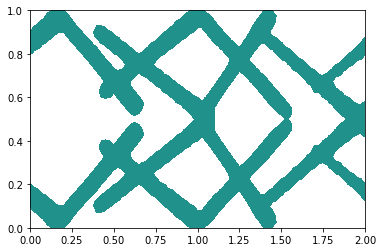

KeyboardInterrupt: 

In [29]:
#Style of plotting
plotting="contour"
# FEM data initialization
M=[nely+1, nelx+1]
EW=DW / nelx # length of element
EH=DH / nely # width of element
x,y=np.meshgrid(np.linspace(0, DW,nelx+1),np.linspace(0,DH,nely+1))
LSgrid={"x":x.flatten(order='F'),"y":y.flatten(order='F')}
# Material properties
h=1 #thickness
E=1
nu=0.3
# Component geometry initialization
x0=np.arange(x_int/2, DW, x_int)# x-coordinates of the centers of components
y0=np.arange(y_int/2, DH, y_int)# y-coordinates of the centers of components
xn=len(x0)# number of component groups in x direction
yn=len(y0)# number of component groups in y direction
x0=np.kron(x0,np.ones((1,2*yn)))
y0=np.matlib.repmat(np.kron(y0,np.ones((1,2))),1,xn)
N=x0.shape[1]# total number of components in the design domain
L=np.matlib.repmat(ini_val[0],1,N)# vector of the lf length of each component
t1=np.matlib.repmat(ini_val[1],1,N) # vector of the half width of component at point A
t2=np.matlib.repmat(ini_val[2],1,N) # vector of the half width of component at point B
t3=np.matlib.repmat(ini_val[3],1,N) # vector of the half width of component at point C
st=np.matlib.repmat([ini_val[4],-ini_val[4]],1,int(N/2)) # vector of the sine value of the inclined angle of each component  
variable=np.vstack((x0,y0,L,t1,t2,t3,st))
#Parameter of MMA
xy00=np.expand_dims(variable.flatten(order='F'),axis=1)
xval=xy00.copy()
xold1=xy00.copy()
xold2=xy00.copy()
move=1.0
#Limits of variable:[x0; y0; L; t1; t2; t3;st];
xmin=np.vstack((0, 0, 0.01, 0.01, 0.01, 0.03, -1.0))
xmin=np.matlib.repmat(xmin,N,1)
xmax=np.vstack((DW, DH, 2.0, 0.2, 0.2, 0.2, 1.0))
xmax=np.matlib.repmat(xmax,N,1)
low=xmin
upp=xmax
m=1; #number of constraint
Var_num=7 # number of design variablesfor each component
nn=Var_num*N
c=1000*np.ones((m,1))
d=np.zeros((m,1))
a0=1
a=np.zeros((m,1))
#Define loads and supports(Short beam)
fixeddofs=np.arange(0,(2*(nely+1)))
alldofs=np.arange(0,2*(nely+1)*(nelx+1))
freedofs=np.setdiff1d(alldofs,fixeddofs)
loaddof=2*(nely+1)*nelx+nely+1
F=csc_matrix(([-1], ([loaddof], [0])), shape=(2*(nely+1)*(nelx+1), 1))
##Preparation FE analysis
nodenrs=np.arange(0,(1+nelx)*(1+nely)).reshape(1+nely,1+nelx,order='F')
edofVec=((2*nodenrs[0:-1,0:-1])).reshape(nelx*nely,1,order='F')
edofMat=np.matlib.repmat(edofVec,1,8)+np.matlib.repmat(np.concatenate([np.array([0,1]),2*nely+np.array([2,3,4,5]),np.array([2,3])],axis=0),nelx*nely,1)
iK=np.kron(edofMat,np.ones((8,1))).T
jK=np.kron(edofMat,np.ones((1,8))).T
EleNodesID=(edofMat[:,(1,3,5,7)]-1)/2
iEner=EleNodesID.T
KE=BasicKe(E,nu, EW, EH,h) # stiffness matrix k**s is formed
#Initialize iteration
p=6
alpha=1e-3 # parameter alpha in the Heaviside function
epsilon=4*min(EW,EH) # regularization parameter epsilon in the Heaviside function
Phi=[None] * N
Loop=1
change=1
maxiter=1000 # the maximum number of iterations
while change>0.001 and Loop<maxiter:
    #Forming Phi^s
    for i in range(0,N):
        Phi[i]=tPhi(np.array(xy00)[np.arange(Var_num*(i+1)-Var_num,Var_num*(i+1))],LSgrid['x'],LSgrid['y'],p)
        
    #Union of components
    tempPhi_max=Phi[0]

    for i in range(1,N):
        tempPhi_max=np.maximum(tempPhi_max,Phi[i])
    
    Phi_max=tempPhi_max.reshape((nely+1,nelx+1),order='F')
   
    #Plot components
    if plotting=="contour":
        plt.contourf(x,y,Phi_max,[0,1])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.show()    

    if plotting== "component":
        for i in range(0,N):
            plt.contour(x,y,Phi[i].reshape(nely+1,nelx+1,order='F'),[0])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.show()
            
    # Calculating the finite difference quotient of H
    H=Heaviside(Phi_max,alpha,nelx,nely,epsilon)
    diffH=[None] * N
    for j in range(0,N):
        for ii in range(0,Var_num):
            xy001=xy00.copy()
            xy001[ii+(j)*Var_num]=xy00[ii+(j)*Var_num]+np.maximum(2*min(EW,EH),0.005)
            tmpPhiD1=tPhi(np.array(xy001)[np.arange(Var_num*(j+1)-Var_num,Var_num*(j+1))],LSgrid['x'],LSgrid['y'],p)
            tempPhi_max1=tmpPhiD1
            for ik in range(0,j):
                tempPhi_max1=np.maximum(tempPhi_max1,Phi[ik])
        
            for ik in range(j+1,N):
                tempPhi_max1=np.maximum(tempPhi_max1,Phi[ik])
                
            xy002=xy00.copy()
            xy002[ii+(j)*Var_num]=xy00[ii+(j)*Var_num]-np.maximum(2*min(EW,EH),0.005)
            tmpPhiD2=tPhi(np.array(xy002)[np.arange(Var_num*(j+1)-Var_num,Var_num*(j+1))],LSgrid['x'],LSgrid['y'],p)
            tempPhi_max2=tmpPhiD2
            for ik in range(0,j):
                tempPhi_max2=np.maximum(tempPhi_max2,Phi[ik])
            for ik in range(j+1,N):
                tempPhi_max2=np.maximum(tempPhi_max2,Phi[ik])
                
            HD1=Heaviside(tempPhi_max1,alpha,nelx,nely,epsilon)
            HD2=Heaviside(tempPhi_max2,alpha,nelx,nely,epsilon)
            if ii==0:
                diffH[j]=(HD1-HD2)/(2*(max(2*np.minimum(EW,EH),0.005))).flatten(order='F')
            else:
                diffH[j]=np.column_stack((diffH[j],(HD1-HD2)/(2*(max(2*np.minimum(EW,EH),0.005))).flatten(order='F'))) 
    #FEA
    denk=np.sum(H[EleNodesID.astype(int)]**2, axis=1) / 4
    den=np.sum(H[EleNodesID.astype(int)], axis=1) / 4
    A1=np.sum(den)*EW*EH
    U=np.zeros((2*(nely+1)*(nelx+1),1))
    sK=np.expand_dims(KE.flatten(order='F'),axis=1)@(np.expand_dims(denk.flatten(order='F'),axis=1).T)
    K = coo_matrix((sK.flatten(order='F'),(iK.flatten(order='F'),jK.flatten(order='F'))),shape=(2*(nely+1)*(nelx+1),2*(nely+1)*(nelx+1))).tocsc()
    # Remove constrained dofs from matrix
    K = K[freedofs,:][:,freedofs]
    # Solve system 
    U[freedofs,0]=spsolve(K,F[freedofs,0])
    #Energy of element
    energy=np.sum((U[edofMat][:,:,0]@KE)*U[edofMat][:,:,0],axis=1)
    sEner=np.ones((4,1))@np.expand_dims(energy,axis=1).T/4
    energy_nod=csc_matrix((sEner.flatten(order='F'), (iEner.flatten(order='F').astype(int),np.zeros((len(sEner.flatten(order='F')),)).astype(int))))
    Comp=F.T@U
    # Sensitivities
    df0dx=np.zeros((Var_num*N,1))
    dfdx=np.zeros((Var_num*N,1))
    for k in range(0,N):
        df0dx[np.arange(Var_num*(k+1)-Var_num,Var_num*(k+1)),0]=(((energy_nod.transpose()).multiply(2)).multiply(H)).dot(diffH[k])
        dfdx[np.arange(Var_num*(k+1)-Var_num,Var_num*(k+1)),0]=np.sum(diffH[k],axis=0)/4
    #MMA optimization
    f0val=Comp
    df0dx=(-df0dx)/np.max(abs(df0dx))
    fval=A1/(DW*DH)-volfrac
    dfdx=dfdx/np.max(abs(dfdx))

    xmma,ymma,zmma,lam,xsi,eta,mu,zet,ss,low,upp=mmasub(m,nn,Loop,xval,xmin,xmax,xold1,xold2, f0val,df0dx,fval,dfdx.T,low,upp,a0,a,c,d,move=1.0)
    xold2=xold1.copy()
    xold1=xval.copy()
    change=np.max(abs(xval-xmma))
    xval=xmma.copy()
    xy00=np.round(xval*1e4)/1e4
    print(' It.: ',Loop, 'Obj.: ' ,f0val, ' Vol.: ', fval, 'ch.:', change)
    Loop+=1